In [1]:
import pandas as pd
import random
from pathlib import Path
random.seed(0)

kl_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_kt={kl_threshold}_re={random_explanations}_l={latents}_{model_last}"
zero_ablation_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_re={random_explanations}_l={latents}_za={zero_ablate}_{model_last}"

base_cfg = {
    "feat_layer": 32,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 1.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
    "latents": "sae",
    "zero_ablate": False
}

def convert_to_single_explanation(df):
    df = df.copy()
    df["explanations"] = df["explanations"].apply(lambda x: random.sample(x, 1))
    df["max_delta_conditional_entropy"] = df.apply(lambda row: row.delta_conditional_entropy_by_explanation[row.explanations[0]], axis=1)
    df["best_explanation"] = df["explanations"].apply(lambda x: x[0])
    return df

# load all results
def load_result(cfg, convert_to_single=True):
    if cfg["zero_ablate"]:
        path = zero_ablation_path_format.format(**cfg)
    else:
        path = kl_path_format.format(**cfg)
    
    path = Path(path) / "generations_scores.json"
    
    df = pd.read_json(path)
    if convert_to_single:
        df = convert_to_single_explanation(df)
    
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explainer_examples,explanations,explainer_prompts,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
0,364.775133,1.088676,0,[<bos> jewelry to meet your specifications. An...,[{'text': ' jewelry to meet your specification...,[{'prompt': ' answers the question:\nEven ball...,[<bos> answers the question:\nEven balloons ha...,[writing],"[ answers the question:\nEven balloons had, o...","{'explanation': None, 'intervention_examples':...","{'writing, numbers, and names': 0.2764968713, ...","{'writing, numbers, and names': 0.162685469200...",0.502246,writing
1,244.986846,1.009252,2,"[<bos>, Florida, at the ESPN Wide World of Spo...","[{'text': ', Florida, at the ESPN Wide World o...","[{'prompt': ', and each team provided impressi...","[<bos>, and each team provided impressive high...",[sports],"[, and each team provided impressive highlight...","{'explanation': None, 'intervention_examples':...","{'sports': 0.1416972478, 'numbers': 0.03998064...","{'sports': 0.1250180878, 'numbers': 0.19923866...",0.141697,sports
2,657.602759,1.069401,3,"[<bos>FIL-TV.WFIL management's presentation, t...",[{'text': 'FIL-TV.WFIL management's presentati...,"[{'prompt': ' way, leave it the fastest way yo...","[<bos> way, leave it the fastest way you can.\...","[court cases, law, etc.]","[ way, leave it the fastest way you can.\nNeve...","{'explanation': None, 'intervention_examples':...","{'court cases, law, etc.': 0.2584279776, 'lega...","{'court cases, law, etc.': 0.17562734530000002...",0.258428,"court cases, law, etc."
3,146.655847,1.018552,6,[<bos> get rid of me aren't you? If I wanted t...,[{'text': ' get rid of me aren't you? If I wan...,[{'prompt': ' anymore.\nAs I searched through ...,[<bos> anymore.\nAs I searched through the bas...,[positive adjectives],[ anymore.\nAs I searched through the basement...,"{'explanation': None, 'intervention_examples':...","{'adjectives, usually describing things as bea...","{'adjectives, usually describing things as bea...",0.043084,positive adjectives
4,587.092242,1.039108,8,"[<bos>10, TYO, west bank, women's development,...","[{'text': '10, TYO, west bank, women's develop...",[{'prompt': ' case and take this opportunity t...,[<bos> case and take this opportunity to exten...,"[numbers, people, places, and things]",[ case and take this opportunity to extend our...,"{'explanation': None, 'intervention_examples':...","{'numbers': 0.34660960830000004, 'nouns': 0.02...","{'numbers': 0.11704934900000001, 'nouns': 0.10...",0.130996,"numbers, people, places, and things"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,391.636679,0.975858,293,"[<bos> sauce. Not having burnt ends, <bos>Nati...","[{'text': ' sauce. Not having burnt ends', 'ma...",[{'prompt': ' sweet little preschool student. ...,[<bos> sweet little preschool student. Was it ...,[leftovers],[ sweet little preschool student. Was it a hin...,"{'explanation': None, 'intervention_examples':...",{'leftovers': 2.0648503304},{'leftovers': 0.5080202097000001},2.064850,leftovers
208,298.847549,1.029635,294,"[<bos> basically a rehearsal, <bos> permitted ...","[{'text': ' basically a rehearsal', 'max_act':...","[{'prompt': 's a huge constitutional', 'top_p_...","[<bos>s a huge constitutional, <bos> high-spee...",[a constitutional issue],"[s a huge constitutional, high-speed trading....","{'explanation': None, 'intervention_examples':...","{'a constitutional issue': 0.2660605113, 'news...","{'a constitutional issue': 0.1574145337, 'news...",0.266061,a constitutional issue
209,721.449687,1.064263,296,[<bos>v/S/htmlS/secondcityt/secondcityt.htm\n-...,[{'text': 'v/S/htmlS/secondcityt/secondcityt.h...,"[{'prompt': ', we can go back and re-judge, bu...","[<bos>, we can go back and re-judge, but right...",[sports],"[, we can go back and re-judge, but right now,..

0.8112981319
0.41603438060000003
0.49742671650000003
3.371370395
0.6000575066
0.5125699441
4.4753051758
0.6328503927
0.6974689643


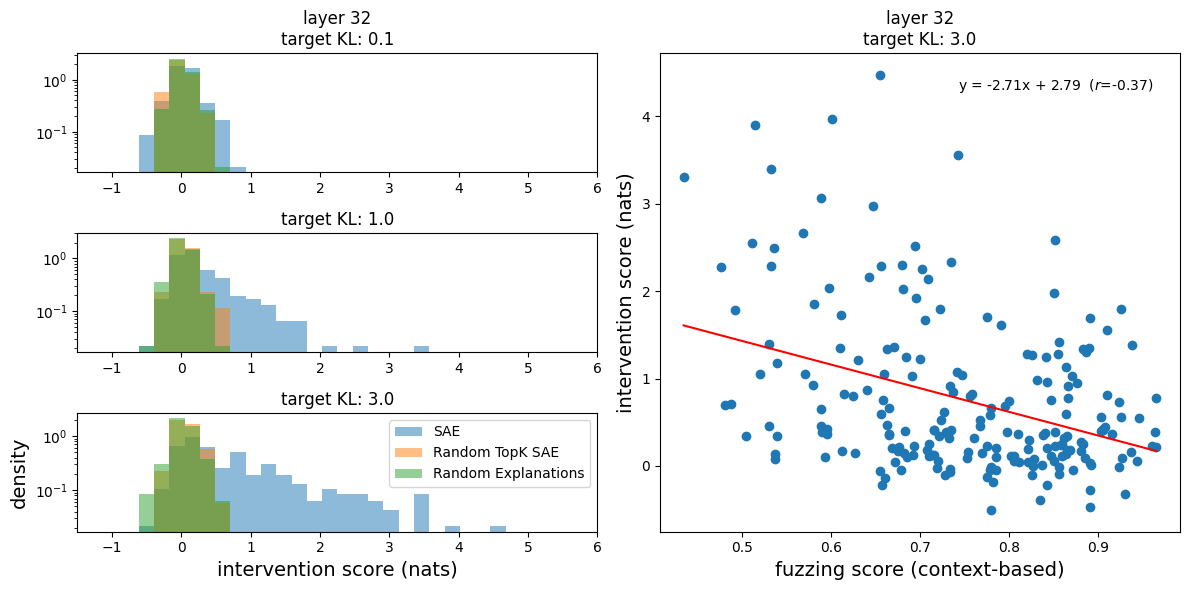

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.stats import linregress

base_cfg = {
    "feat_layer": 32,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 3.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
    "latents": "sae",
    "zero_ablate": False
}

kls = [0.1, 1.0, 3.0]
layers = [32]
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])
convert_to_single = True

for i, kl in enumerate(kls):
    df, rsae_df, rexpl_df = None, None, None
    for j, layer in enumerate(layers):
        cfg = base_cfg.copy()
        cfg["feat_layer"] = layer
        cfg["kl_threshold"] = kl
        df = pd.concat([df, load_result(cfg, convert_to_single=convert_to_single)])
        rsae_cfg = cfg.copy()
        rsae_cfg["latents"] = "random"
        rsae_df = pd.concat([rsae_df, load_result(rsae_cfg, convert_to_single=convert_to_single)])
        rexpl_cfg = cfg.copy()
        rexpl_cfg["random_explanations"] = True
        rexpl_df = pd.concat([rexpl_df, load_result(rexpl_cfg, convert_to_single=convert_to_single)])
    
    ax = fig.add_subplot(gs[i, 0])
    mi, ma = -1.5, 6.0
    bins = np.linspace(mi, ma, 35)
    print(df["max_delta_conditional_entropy"].max())
    print(rsae_df["max_delta_conditional_entropy"].max())
    print(rexpl_df["max_delta_conditional_entropy"].max())
    ax.hist(df["max_delta_conditional_entropy"], bins=bins, alpha=0.5, label="SAE", density=True)
    ax.hist(rsae_df["max_delta_conditional_entropy"], bins=bins, alpha=0.5, label="Random TopK SAE", density=True)
    ax.hist(rexpl_df["max_delta_conditional_entropy"], bins=bins, alpha=0.5, label="Random Explanations", density=True)
    if i == 0:
        layers_text = f"layers {', '.join([str(l) for l in layers[:-1]])} and {layers[-1]}" if len(layers) > 1 else f"layer {layers[0]}"
        ax.set_title(f"{layers_text}\ntarget KL: {kl}")
    else:
        ax.set_title(f"target KL: {kl}")
    ax.set_xlim(mi, ma)
    ax.semilogy()
    if i == 2:
        ax.set_ylabel("density", fontsize=14)
        ax.set_xlabel("intervention score (nats)", fontsize=14)
        ax.legend(fontsize=10)

input_score = "fuzzing"
input_df = None
output_df = None
layers = [32]
for fl in layers:
    path = f"counterfactual_results/{input_score}_{base_cfg['feat_layer']}.json"
    with open(path, "r") as f:
        data = json.load(f)

    input_df = pd.concat([input_df, pd.DataFrame([{"feat_idx": int(k.split("feature")[-1]), "feat": k, "score": data[k]["score"], "explanations": data[k]["explanations"]} for k in data.keys()])])
    cfg = base_cfg.copy()
    cfg["feat_layer"] = fl
    output_df = pd.concat([output_df, load_result(cfg, convert_to_single=convert_to_single)])

joined_df = input_df.merge(output_df, on="feat_idx")

linr = linregress(joined_df["score"], joined_df["max_delta_conditional_entropy"])

ax4 = fig.add_subplot(gs[:, 1])
plt.sca(ax4)
plt.scatter(joined_df["score"], joined_df["max_delta_conditional_entropy"], alpha=1.0)
plt.plot(joined_df["score"], linr.intercept + linr.slope * joined_df["score"], color="red")

plt.text(0.95, 0.95, f"y = {linr.slope:.2f}x + {linr.intercept:.2f}  ($r$={linr.rvalue:.2f})", 
          transform=ax4.transAxes, verticalalignment='top', horizontalalignment="right")

layers_text = f"layers {', '.join([str(l) for l in layers[:-1]])} and {layers[-1]}" if len(layers) > 1 else f"layer {layers[0]}"
plt.title(f"{layers_text}\ntarget KL: {kl}")
plt.xlabel(f"{input_score} score (context-based)", fontsize=14)
plt.ylabel(f"intervention score (nats)", fontsize=14)
plt.tight_layout()
plt.savefig(f"_figures/hists_and_scatter_cts={convert_to_single}.pdf", bbox_inches="tight")
plt.show()

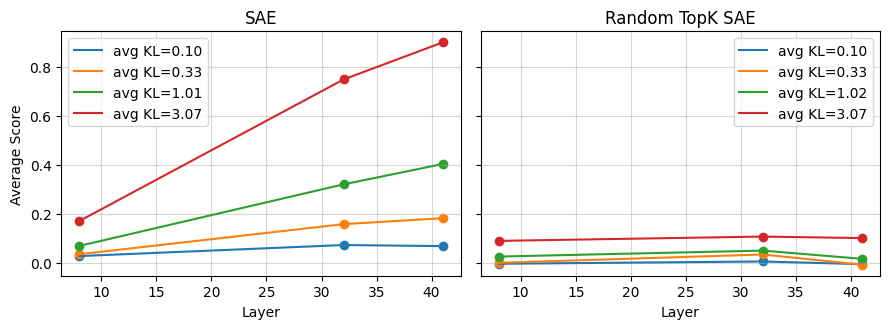

In [3]:
import numpy as np

# Score vs Layer at each KL threshold and zero-ablation
kl_thresholds = [0.1, 0.33, 1.0, 3.0]
layers = [8, 32, 41]
convert_to_single = True

fig, axs = plt.subplots(1, 2, figsize=(9, 3.4), sharey=True)
for i, latents in enumerate(["sae", "random"]):
    plt.sca(axs[i])
    plt.grid(True, alpha=0.5)
    for kl in kl_thresholds:
        used_layers = []
        avg_scores = []
        avg_kls = []
        for feat_layer in layers:
            cfg = base_cfg.copy()
            cfg["feat_layer"] = feat_layer
            if kl is None:    
                cfg["zero_ablate"] = True
            else:
                cfg["kl_threshold"] = kl
            cfg["latents"] = latents
            cfg["random_explanations"] = False
            try:
                df = load_result(cfg, convert_to_single=convert_to_single)
            except FileNotFoundError as e:
                print(f"File not found for {cfg}: {e}")
                continue
            avg_kls.append(df['avg_kl'].values.mean())
            avg_scores.append(df['max_delta_conditional_entropy'].values.mean())
            used_layers.append(feat_layer)
        label = f"zero-ablate (avg KL={np.mean(avg_kls):.2f})" if kl is None else f"avg KL={np.mean(avg_kls):.2f}"
        plt.plot(used_layers, avg_scores, label=label)
        plt.scatter(used_layers, avg_scores)
    plt.xlabel('Layer')
    if i == 0:
        plt.ylabel('Average Score')
    plt.legend()
    plt.title("SAE" if latents == "sae" else "Random TopK SAE")
plt.tight_layout()
plt.savefig(f"_figures/avg_scores_vs_layer.pdf", bbox_inches="tight")
plt.show()


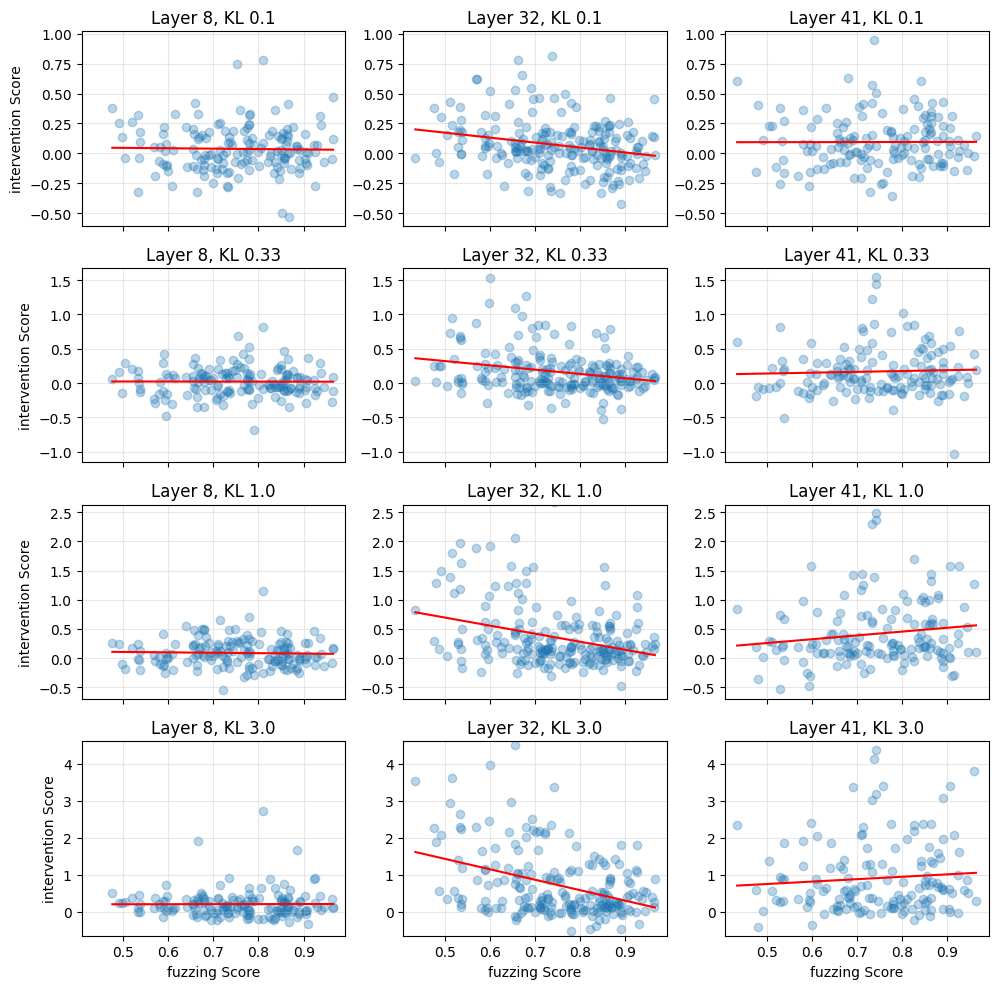

In [4]:
import numpy as np

# Score vs Layer at each KL threshold and zero-ablation
kl_thresholds = [0.1, 0.33, 1.0, 3.0]
layers = [8, 32, 41]
convert_to_single = True
input_score = "fuzzing"

base_cfg = {
    "feat_layer": 32,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 1.0,
    "random_explanations": False,
    "latents": "sae",
    "model_last": "gemma-2-9b",
    "zero_ablate": False
}

fig, axs = plt.subplots(len(kl_thresholds), len(layers), figsize=(10, 10), sharex=True)
for j, kl in enumerate(kl_thresholds):
    for i, fl in enumerate(layers):
        plt.sca(axs[j, i])
        cfg = base_cfg.copy()
        cfg["feat_layer"] = fl
        cfg["kl_threshold"] = kl
        
        output_df = load_result(cfg, convert_to_single=convert_to_single)
        
        path = f"counterfactual_results/{input_score}_{base_cfg['feat_layer']}.json"
        with open(path, "r") as f:
            data = json.load(f)

        input_df = pd.DataFrame([{"feat_idx": int(k.split("feature")[-1]), "feat": k, "score": data[k]["score"], "explanations": data[k]["explanations"]} for k in data.keys()])
        joined_df = input_df.merge(output_df, on="feat_idx")
        linr = linregress(joined_df["score"], joined_df["max_delta_conditional_entropy"])
        plt.scatter(joined_df["score"], joined_df["max_delta_conditional_entropy"], alpha=0.3)
        plt.plot(joined_df["score"], linr.intercept + linr.slope * joined_df["score"], color="red")
        plt.title(f"Layer {fl}, KL {kl}")
        if j == 3:
            plt.xlabel(f"{input_score} Score")
        if i == 0:
            plt.ylabel("intervention Score")
        plt.grid(True, alpha=0.3)

    for ax in axs[j, :2]:
        ax.sharey(axs[j, 2])

plt.tight_layout()
plt.savefig(f"_figures/intervention_vs_fuzzing_scores.pdf", bbox_inches="tight")
plt.show()

In [5]:
import os
# for pa in Path("counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=0.1_re=False_l=random_gemma-2-9b").glob("generations_scores.json"):
for gens_pa in Path("counterfactual_results").glob("nf=*/generations.json"):
    # print(pa)
    pa = gens_pa.parent / "generations_scores.json"
    if "fl=16" in str(pa) or "fl=24" in str(pa) or "fl=40" in str(pa):
        continue
    if not pa.exists():
        print(f"CUDA_VISIBLE_DEVICES=0    python /mnt/ssd-1/alexm/sae-auto-interp/run_score_generations.py  --expl_path \"{gens_pa}\"  --explainer_name \"meta-llama/Meta-Llama-3.1-8B\" ")
        continue
    if len(pa.read_text()) == 0:
        # pa.rename(pa.parent / f"empty_{pa.name}")
        continue
    scores_df = pd.read_json(pa)
    gens_df = pd.read_json(gens_pa)
    if len(gens_df) != len(scores_df):
        print(f"Mismatch in length between {gens_pa} and {pa}: {len(gens_df)} != {len(scores_df)}")
        continue
    for row in scores_df.iloc:
        compls = row.completions
        nontruncateds = []
        for compl in compls:
            text = compl["text"]
            if compl["completions"]["clean"].startswith(text) or compl["completions"]["intervened"].startswith(text):
                nontruncateds.append(compl)
            if text == "":
                print(row.feat_idx, compl)
        if len(nontruncateds) > 0:
            pa.rename(pa.parent / f"nontruncated_{pa.name}")
            print(f"CUDA_VISIBLE_DEVICES=0 python /mnt/ssd-1/alexm/sae-auto-interp/run_score_generations.py  --expl_path \"{gens_pa}\"  --explainer_name \"meta-llama/Meta-Llama-3.1-8B\" ")
            break
    
